## Examples

Why is clustering useful?
- for data analysis - when you analyze a new dataset it can be usfelu running a clustering algorithm and then analysing each cluster separately
- dimensionality reduction - when you have k clusters you can replace an instance x with the vector of its cluster affinities. This will wiled a lower k-dimensional vector
- Segmenting an image - if we cluster the data according to their color and then replace each instance color with the respective mean cluster color, it is possible to reduce the overall number of colors in an image, making it easier to analyze. Note that this is just another dimensionality reduction task.  

#### k-means
This one here is the easiest yet powerful clustering algorithm. It is a parametric one, since it assumes the clusters in the data to have a spherical shape. 

**Note** Scaling feature beforehand generally improves the algorithm performance.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

x,y = make_blobs(n_samples=500, random_state=42, centers=5)

k = 5 # the algorithm will detect five clusters
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X=x)

In [ ]:
# data visualization
from matplotlib.pyplot import scatter
scatter(x[:,0], x[:,1])

In [ ]:
# predictions
kmeans.labels_

In [ ]:
# overall result
import matplotlib.pyplot as plt
def plotting_clusters(alg, x):
    # data 
    plt.plot(x[:,0], x[:,1], "y^", label = "data")
    # centroid coordinates
    centers = alg.cluster_centers_
    i = 0
    for c in centers:
        plt.plot(c[0], c[1], "bs", label = f"centroid {i}")
        i += 1
    plt.legend(loc="lower right", fontsize=8)
plotting_clusters(kmeans, x)
# plt.savefig("k means cluster")

In [ ]:
# prediction making
X_new, y_new = make_blobs(20, random_state=42, centers= 5)
kmeans.predict(X_new)
plotting_clusters(kmeans, X_new)

In general k-means is an algorithm used to perform hard-clustering, meaning that each instace is assignes only to one cluster per time. In some cases it might be useful to be a little more conservative, performing soft-sclutering. In this case the algorithm will output a score (often a probability) for each point to belong to a cluster. In k-means it is reasonable thinking that such a score coud be the distance of each point to the centroids.

In [ ]:
kmeans.transform(X_new)

In general k-means algorithm places the centrois in a random way choosing k instances among the data at random. If you already have a sense about where the centroids should be placed at the beginning, you can tell their coordinates. 

In order to avoid doing this, in sklearn the centroid placing method used is the K-means++ by default. The goal is finding an efficient way of spreading the centroids the most. Here's how it works:
1. select the first centroid at random within the training instances
2. assign to each pint in the dataset a probility measure proportional to the distance squared from the closest centroid
3. draw a new centroid accoringly to the probabilities assigned to the data

In [ ]:
# setting manually the centroids
start = ([[-3,3], [-3,2], [-3,1], [-1,2], [0,2]])
kmeans_new = KMeans(n_clusters=5, init=start)

Finally we need to address the last two important things:
- assessing model performance - this can be done by using as performance measure the sum over all datapoints of the squared distance from the respective centroid
- controoling the number of runs performed - kmeans strongly depedns from the initial centroids position. Since we place them casually different runs of the algorithm will yield different results. By default sklearn runs the algorithm 10 times and outputs the best clustering results, based upon the above performance measure

In [ ]:
# performance measure: inertia
kmeans.inertia_
# score: - inertia (every score in sklearn is interpreted by the rule "greater is better")
kmeans.score(x)

In [ ]:
# setting the number of iterations to be performed
kmeans_new = KMeans(n_clusters=4, n_init=6)

##### Finding the optimal number of clusters

The number of clusters k in k-means in the only hyperparameter to set. It impacts a lot the model performance, so it pretty important getting if right. The best idea is using some performance measures, like the inertia.

Using inertia we could make a plot of model inertia wrt to the number of clusters. Then we look for the elbow in the plot. 

In [ ]:
# dgp
x,y = make_blobs(n_samples=500, random_state=42, centers=5)

In [ ]:
# model creation and training
kmeans = KMeans(n_clusters=5, random_state= 42)
kmeans.fit(x)

In [ ]:
from numpy import arange
from matplotlib import pyplot as plt

k_val = arange(1,10)
performance = []

for k in k_val: 
    k = int(k)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    performance.append(kmeans.inertia_)

plt.plot(k_val, performance,"o-r")
plt.xlabel("k")
plt.ylabel("inertia")
# plt.savefig("elbow")

Another important performance measure for clustering is the silhoutte coefficient. 

In [ ]:
from sklearn.metrics import silhouette_score
from numpy import arange
from matplotlib import pyplot as plt

k_val = arange(2,10)
performance = []

for k in k_val: 
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    labels = kmeans.labels_
    performance.append(silhouette_score(x, labels))

plt.plot(k_val, performance,"o-b")
plt.xlabel("k")
plt.ylabel("silhoutte score")
plt.savefig("silhoutte_score")

The silhoutte coefficient give more information then the inertia score. So better be using it.

##### k-means application

- preprocessing the data (dimensionality reduction) 

We cluster the data in k different clusters, then we substitute an instance features with cluster similarity for each cluaster we have found. This wai we'll reduce the training instances to be k-dimensional.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_digits # 8x8 pixel instances, 64 features
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
X, y = load_digits(return_X_y=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# before using clustering for preprocessing the data
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

In [ ]:
# using clustering for preprocessing the data
model = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=50)), # instances now have 50 features, one for each culster similarity score 
    ("log_reg", LogisticRegression(max_iter=3000))
])

model.fit(X_train, y_train)
model.score(X_test, y_test)

Another important feature of using clustering for data preprocesing is that the number of clusters k is just another hyperparameter of the overall model. So we can find the best value for it by GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2,100))
grid_clf = GridSearchCV(model, param_grid=param_grid, cv =3)
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

#### DBSCAN and HBDSCAN

This clustering algorithm can be seen as the non-parametric counterpart of k-means. It doesn't make any assumptions beforehand about the clusters form. Yet it is more difficult to tune, the value of $\epsilon$ is very nasty to get right

In [ ]:
from sklearn.datasets import make_moons
from matplotlib.pyplot import scatter

X, y = make_moons(n_samples=1000, noise = 0.05)
scatter(X[:,0], X[:,1])

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.05, min_samples=5)
dbscan.fit(X)
dbscan.labels_  # note that this algorithm finds 7 different clusters, not a good job
# label = -1 when the point has been labelles as noise and thus dropped

If we want to avoid the burden of chosing $\epsilon$ we may try ti use the HDSCAN algorithm. That is a non-parametric, hierarchical clustering algorithm (see notes for more). It has only one hyperparameter, that is the minimum number of instances that must be found in a cluster to be one. 

In [ ]:
from sklearn.cluster import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=5) # default: n_samples = 5
hdbscan.fit(X)
hdbscan.labels_ # 2 clusters are correctly found, labels = {0,1}

This last algorithm is very powerfu and easy to use. A reccomandation is using it as work-horse. It is very flexible and pretti efficient, so you can alway use this one without worrying too much at a first approach with the data 

#### Gaussian Mixtures

Yet another parametric clustering algorithm. The difference here is that the clustering is performed following a soft approach, meaning that we ooutput a probability of each instance to belong to a certain cluster. 

The parametric assumption we make is that the data were drawm from a sum of multivariate gaussian distributions. The algorithm, loogking at the data, tries finding the parameters of each one of this mvn distributions. 

The number of mvn to consider is the only hyperparameter of this algorithm. 

In [ ]:
# dgp
from sklearn.datasets import make_moons
from matplotlib.pyplot import scatter

X, y = make_moons(n_samples=1000, noise = 0.05)

In [ ]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2, n_init = 10)
gm.fit(X)

In [ ]:
# parameters estimated
print(f"weights: {gm.weights_},means: {gm.means_},covarancies: {gm.covariances_}")

The parameter weights is an estimate of how important every mvn estimated is, meaning how many samples were most likely drawn from it: the higher, the more sampes were drawm from that distrbution (likely)

In [ ]:
# checking convergence 
gm.converged_

In [ ]:
# checking number of iterations needed for converging
gm.n_iter_

In [ ]:
# predictions: instances are assigned to the most likely cluster, highest probability computed
gm.predict(X)
# soft predictions: probs for every instance of being drawn from one of the mvn
gm.predict_proba(X) 
# local probability density estimation 
# for each point given, this method uses the computed mvn distribution to output the approximate log pdf 
# value in that point
gm.score_samples(X)[0]

We can also limit the number of shapes the clusters we find. This will help the algorithm, decreasing the total number of parameters it needs to find in order to converge.

The possible shapes you can set is:
- "spherical": for spherical clusters
- "diag": for ellipsoid clusters
- "tied": for ellipsoid cluster of the same size

By default the algorithm will look for clusters of any shape and size.

In [ ]:
gm = GaussianMixture(n_components=2, covariance_type="spherical")

For assessing the performance of a gm model we can use penalized theoretical information criterion:
- BIC (favoring less complex models)
- AIC

The higher they are, the worse the model is. 

In [ ]:
gm.bic(X)
gm.aic(X)

Thus, they can be used for finding the best overall GMM, looking at what combination of hyperparameters yields the lowest value.

## Exercises

1. How would you define clustering? Can you name a few clustering algorithms?

Clustering is an un-supervised learning task. It stands for the process of grouping the data we have wrt a similarity measure of our choice. 

Clustering algorithms can be divided according to two different criteria: parametric and non parametric, soft and hard.  

One of them for each class: 
- parametric and hard: k-means 
- parametric and soft: Gaussian mixture models (GMM)
- non-parametric and hard: DBSCAN
- non-parametric and soft: HDBSCAN 

2. Describe two techniques to select the right number of clusters when using k-means

The first one is looking at the inertia score. The inertia value is computed pretty much a RSS, using the euclidean distance of a point from the nearest centroid for all the points in the dataset. The higher the inertia value, the worst the clustering result is. It also gets lower the more cluster we look for (as k increases).

The second one is the silhoutte coefficient. This is computed for every point as:
$$s_{\text{coefficient}} = \frac{b-a}{\max{(b;a)}}$$
where:
- a is the mean distance of the point from the nearest centroid
- b is the mean distance of the point from the other centroids, excluded the closest one. 
The silhoutte score of the algorithm is the mean value over the data points silhoutte score. 

It varies from [-1,1], the higher the better. It is 1 when $a=0$, this happens only if every point of each cluster is positioned exactly on top of the relative centroid: perfect clustering. It is -1 if $b=0$, meaning that every point is hardly bad-clustered in a cluster $C_j$, but finds itself on top of another centroid $C_k$ ( $j \neq k$ ).

3. Can you name two algorithms that can scale on large datasets? can you name two algorithms that look for regions of high density? 

Two alg. that can scale on large datasets are: 
- mini-batch k-means
- stochastic k-means

Two alg. that look for regions of high density are:
- DBSCAN (and the soft cousin HDBSCAN)
- GMM

4. What is a Gaussian mixture?

A Gaussian mixture model (GMM) is a soft, parametric algorithm. The idea behing it is that the data we have, were drowm from a population having a probability distribution equal to the sum of various multivariate normal distributions. The algorithms, looking at how the data are spread across the feature space and using an algorithm on likelihood maximizing, find the parameters for all the mvn in the overall population we think mught exist. 

Note that this number is an hyperparameter of the model. Once the mvn are estimated, at each point a probability of belonging to a certaing cluster is assigned. Then a point is assigned to the cluster who's most probable being with, based upon the probabilities assegnid before. 

5. Can you name two techniques to find the right number of clusters when using a GMM? 

For assessing the performance of a GMM, since for how it works it outputs an estimate of the overall population distribution, parametrized as a linear combination of mvn, penalized likelihood values for the model would be on point. For assessing the performance for this kind of models, we can use something like AIG and BIC, the lower they are, the better the model is. 

$$\text{BIC} = p\log(m) - 2 \log(L)$$
$$\text{AIC} = 2p - 2 \log(L)$$

where:
- m is the number of instances
- p is the number of parameters the model learnt
- L is the maximized likelihood function of the model. In general the likelihood gives the probability of a specific parameter value given the instances. The parameter value that maximizes the likelihood is called maximum likelihood estimator. 

A lower value of AIC and BIC means that the model has a great value for the maximized likelihood function, that is to say the parameters values estimated (the mean and covariance matrix of every mvn in the parametrized population distribution) are very likely to be the true ones, given the data we are working with. 

In a few words, if AIC and BIC are low we have done a great job. Thus they can be used as coefficients to select the right number of clusters when using GMM, which will be the one to minimize AIC and BIC. 

6. Perform clustering on the Olivetti faces dataset and fin-tune it, findingg the right number of clusters. Then visualize the clusters: do you see similar faces in each cluster? 

In [99]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import StratifiedShuffleSplit

# 400 images of 64x64 pixels
X,y = fetch_olivetti_faces(return_X_y=True)

# performing stratified sampling to be sure that both in training and test set are representative of 
# all the data

# creaing test and training set
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
# next() is used to return both the output values of the strat_split.split() method in one line
train_valid_idx, test_idx = next(strat_split.split(X,y))
X_train_val, y_train_val = X[train_valid_idx], y[train_valid_idx]
X_test, y_test = X[test_idx], y[test_idx]

# creating a validation set from the training set
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, val_idx = next(strat_split.split(X_train_val, y_train_val))
X_train, y_train = X_train_val[train_idx], y_train_val[train_idx]
X_val, y_val = X_train_val[val_idx], y_train_val[val_idx]

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

In [100]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN
import matplotlib.pyplot as plt

In [ ]:
# performing PCA for dimensionality reduction purposes
pca = PCA(0.99)

# perform PCA on the training set, since it has more instances 
pca.fit(X_train)

# transform the data, projecting each instance in the lower dimensional pc space
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

pca.n_components_

In [ ]:
# training k-means models, k varying
k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

In [ ]:
# using inertia value to find the best k
score = []

for m in kmeans_per_k:
    score.append(m.inertia_)

plt.plot(k_range, score, "o-r")
plt.xlabel("k")
plt.ylabel("inertia")

In [ ]:
# using silhoutte score to find the best k
from numpy import argmax
from sklearn.metrics import silhouette_score
score = []

for m in kmeans_per_k:
    score.append(silhouette_score(X_train_pca, m.labels_))

best_k_idx = argmax(score)
best_k = k_range[best_k_idx]
best_score = score[best_k_idx]

plt.figure(figsize=(8,3))
plt.plot(k_range, score, "o-r")
plt.plot(best_k, best_score, "bs")
plt.xlabel("k")
plt.ylabel("silhoutte coefficient")

In [ ]:
print(best_k, best_score)

In [ ]:
best_model = KMeans(n_clusters=best_k)
best_model.fit(X_train_pca)

It looks like the best number of clusters is quite high, at 75. You might have expected it to be 40, since there are 40 different people on the pictures. However, the same person may look quite different on different pictures (e.g., with or without glasses, or simply shifted left or right).

In [ ]:
# visualize the clusters
import numpy as np

def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

In [ ]:
# now let's try a HDBSCAN model 
hdb = HDBSCAN()
hdb.fit(X_train_pca)

In [ ]:
silhouette_score(X_train_pca, hdb.labels_)

An HDBSCAN performs badly on the data.

In [ ]:
# let's try DBSCAN, fine tuning the epsilon parameter

eps_range = np.arange(100,105, 0.1,)
models = []

for eps in eps_range:
    model = DBSCAN(eps=eps)
    print("training DBSCAN with epsilon={}".format(eps))
    models.append(model.fit(X_train_pca))

In [ ]:
scores = []

for model in models:
    print(model.labels_)

The DBSCAN algorithm doesn't work. it only fids one big cluster, even for very high values of epsilon.

7. Continuing on the Olivetti faces dataset, use k-means as a dimensionality reduction tool and check if the overall model performance improves. 

In [97]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train_pca, y_train)
rfc.score(X_val_pca,y_val)

0.9125

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

pip = Pipeline([
    ("kmeans", KMeans()),
    ("rf", RandomForestClassifier())
])



0.2

In [ ]:
# fine-tuning the hyperparameter 
k_range = range(5, 150, 5)
scores = []

for k in k_range:
    pip = pip = Pipeline([
    ("kmeans", KMeans(n_clusters=k)), # transform the feature space in a cluster distance space
    ("rf", RandomForestClassifier())
])
    pip.fit(X_train_pca, y_train)
    print(f"k={k}, accuracy={pip.score(X_val_pca, y_val)}")
    scores.append(pip.score(X_val_pca, y_val))

k=5, accuracy=0.3875
k=10, accuracy=0.5625
k=15, accuracy=0.575
k=20, accuracy=0.6125
k=25, accuracy=0.675
k=30, accuracy=0.6375
k=35, accuracy=0.65
k=40, accuracy=0.725
k=45, accuracy=0.65
k=50, accuracy=0.7
k=55, accuracy=0.725
k=60, accuracy=0.7
k=65, accuracy=0.7
k=70, accuracy=0.675
k=75, accuracy=0.7625
k=80, accuracy=0.7375
k=85, accuracy=0.75
k=90, accuracy=0.7625
k=95, accuracy=0.725
k=100, accuracy=0.75
k=105, accuracy=0.725
k=110, accuracy=0.7625
k=115, accuracy=0.75
k=120, accuracy=0.7125
k=125, accuracy=0.7625
k=130, accuracy=0.7625
k=135, accuracy=0.7375
k=140, accuracy=0.725
k=145, accuracy=0.7625


In [105]:
best_k_idx = argmax(scores)
best_k = k_range[best_k_idx]
best_score = scores[best_k_idx]

<Figure size 1000x300 with 0 Axes>

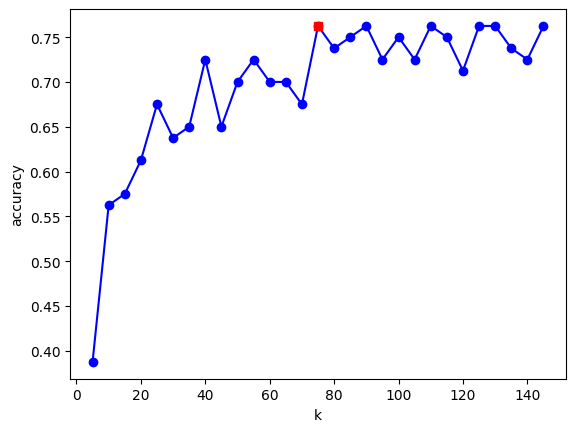

<Figure size 1000x300 with 0 Axes>

In [108]:
plt.plot(k_range, scores, "o-b")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.plot(best_k, best_score, "rs")
plt.figure(figsize=(10,3))

In [109]:
# best k
print(best_k, best_score)

75 0.7625


In [110]:
# comparison 
print(rfc.score(X_val_pca, y_val))
print(best_score)

0.9125
0.7625


rfc performed clearly better without using the kmeans as a dimensionality reduction algorithm. 

We could also try to add the cluster distance features to each instance in tho orgiinal data set and check if the proformance of the model gets better, having data with more features to train on.

In [112]:
from sklearn.pipeline import Pipeline

for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_val_pca, y_val))

5 0.4
10 0.4375
15 0.5875
20 0.6
25 0.6625
30 0.6625
35 0.6625
40 0.675
45 0.6625
50 0.6875
55 0.75
60 0.6875
65 0.725
70 0.7
75 0.7375
80 0.725
85 0.7625
90 0.775
95 0.775
100 0.7625
105 0.75
110 0.725
115 0.7625
120 0.7625
125 0.7375
130 0.7375
135 0.725
140 0.8
145 0.725


With k=140 we obtained a score of 0.8, a better performance overall. 